In [0]:
#!pip install xgboost --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

import xgboost as xgb
import joblib

In [0]:
df = pd.read_csv("/dbfs/FileStore/tables/consultas.csv", sep=";")
df["Datetime"] = pd.to_datetime(df["Data"], format='%b %d, %Y')
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df = df[["Consultas"]]
df.head()

,Consultas
Datetime,
2023-01-01,503
2023-01-02,1131
2023-01-03,1095
2023-01-04,1024
2023-01-05,1106


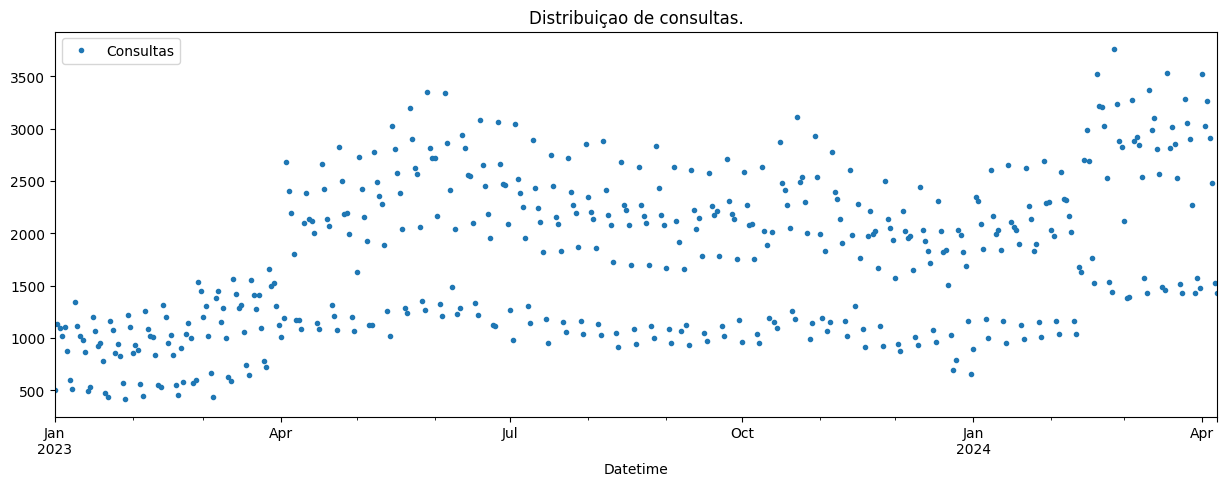

In [0]:
df.plot(style='.',
        figsize=(15,5),
        color = color_pal[0],
        title = "Distribuiçao de consultas.")
plt.show()

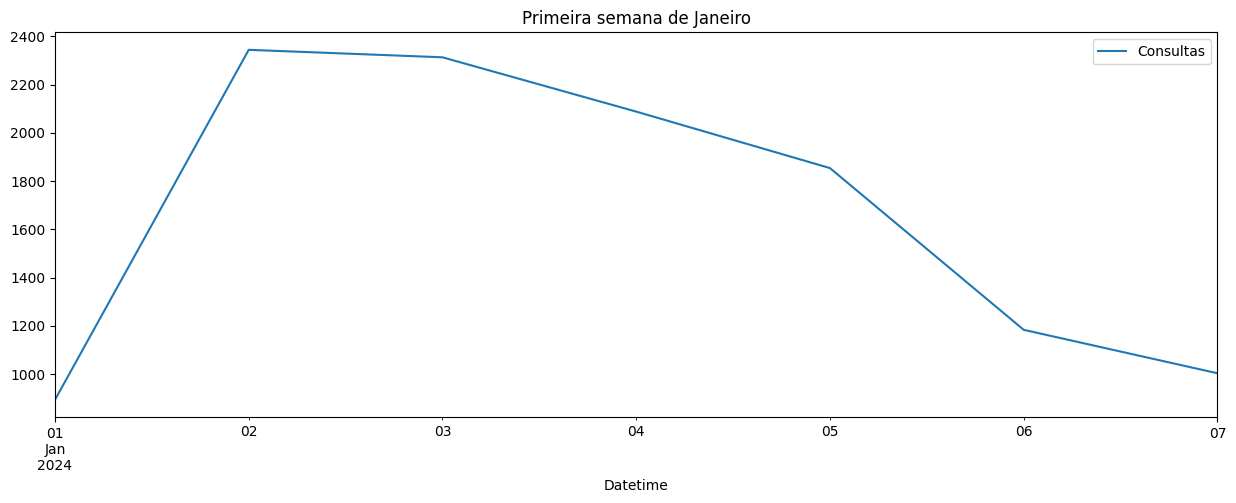

In [0]:
df.loc[(df.index >= "2024-01-01") & (df.index <= "2024-01-07")].plot(figsize=(15,5),
                                                                   title="Primeira semana de Janeiro")
plt.show()

## Features

In [0]:
def new_features(df):
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year

    return df

df = new_features(df)

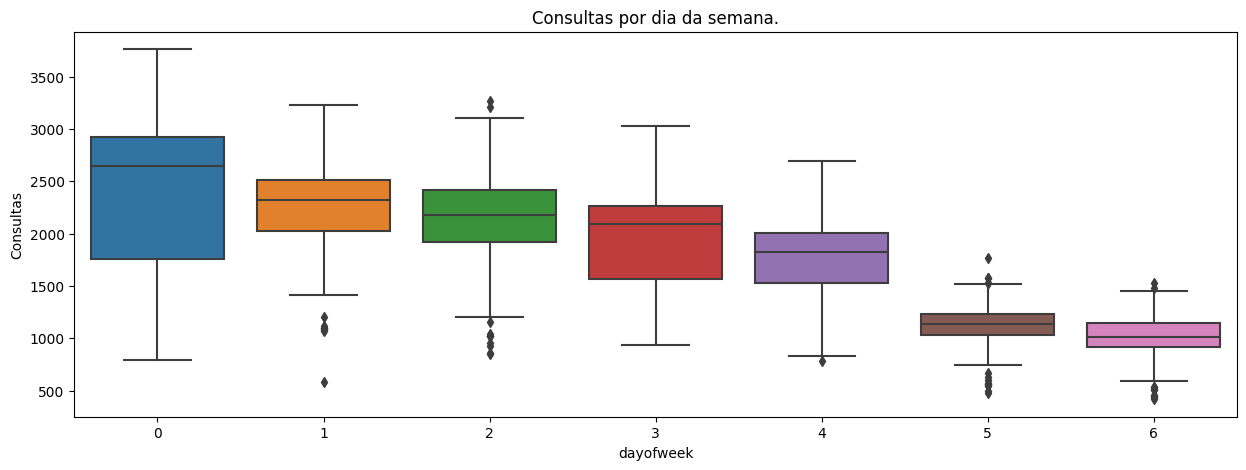

In [0]:
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df,
            x = "dayofweek",
            y = "Consultas")
ax.set_title("Consultas por dia da semana.")
plt.show()

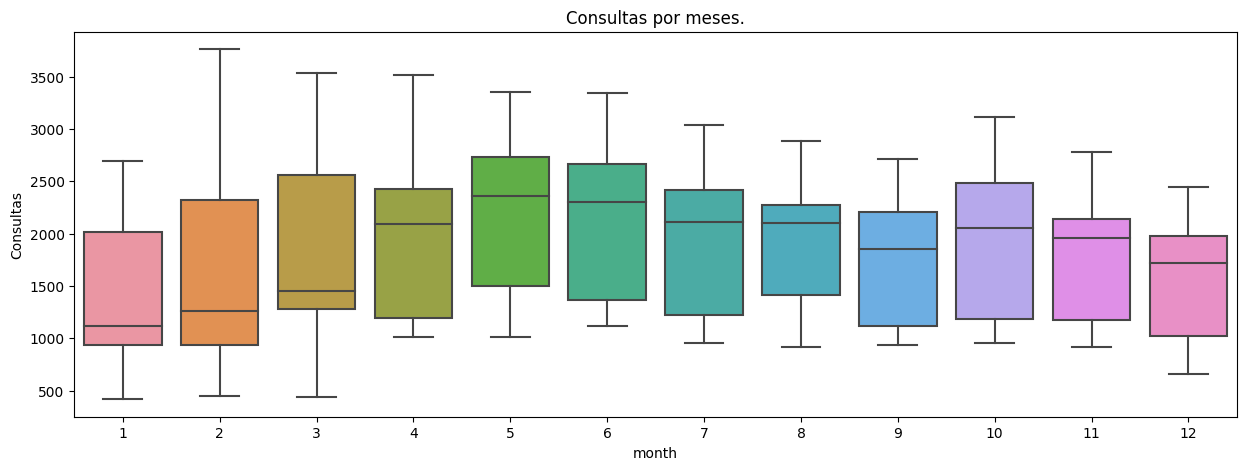

In [0]:
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df,
            x = "month",
            y = "Consultas")
ax.set_title("Consultas por meses.")
plt.show()

## Split data

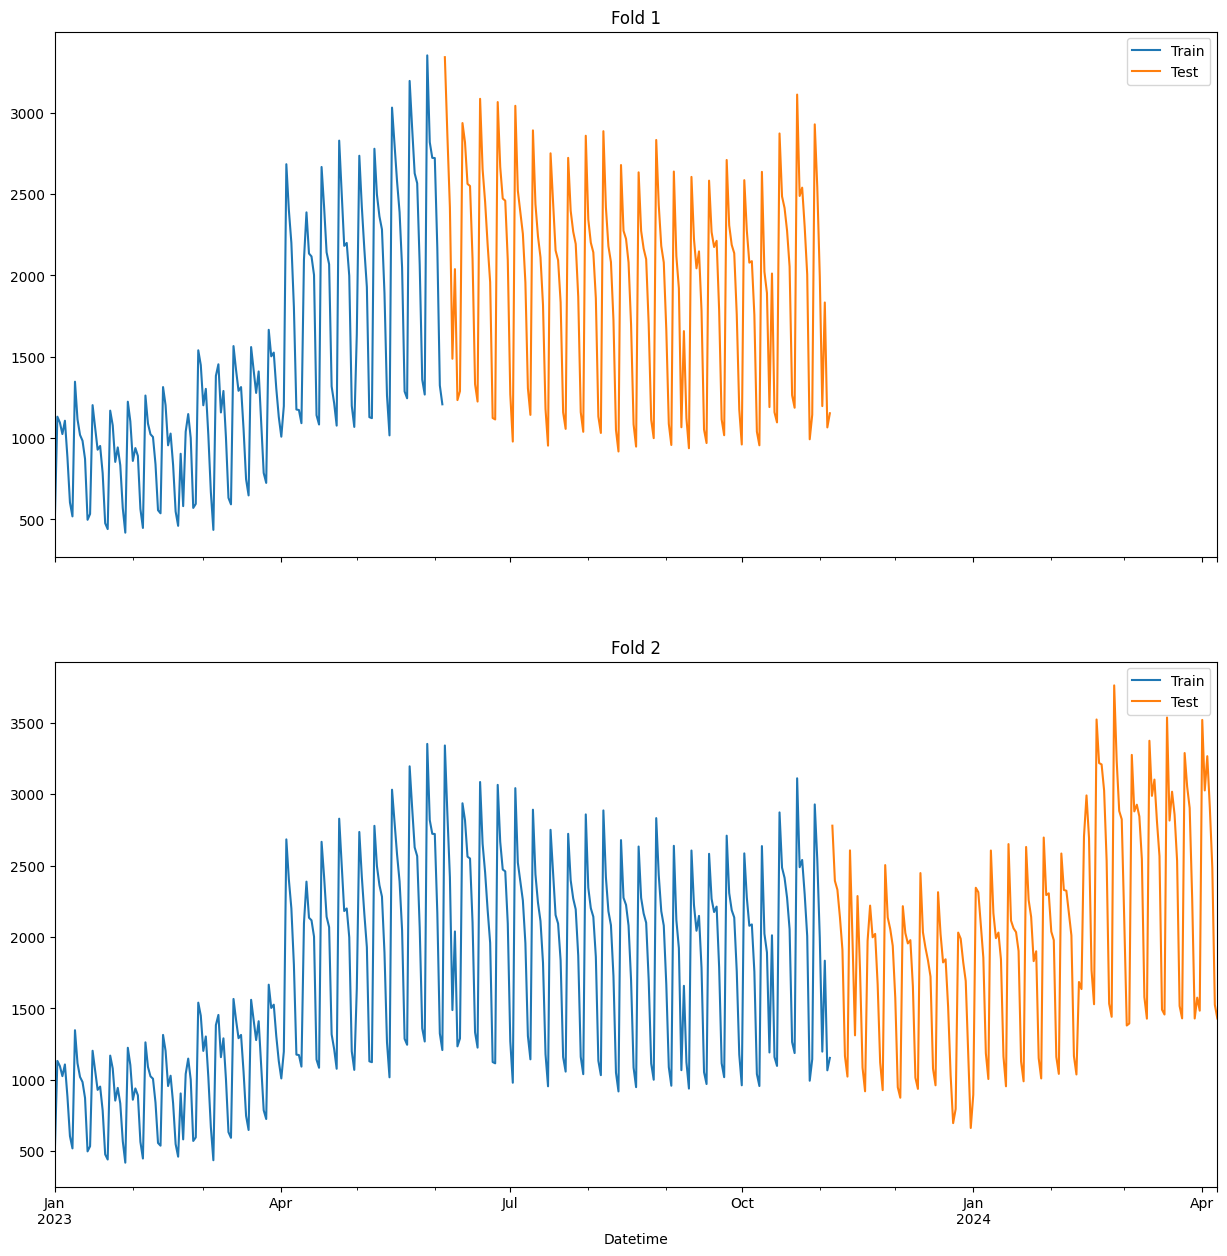

In [0]:
tscv = TimeSeriesSplit(n_splits=2)
df = df.sort_index()

fig, axs = plt.subplots(nrows=2,
                        ncols=1,
                        figsize=(15, 15),
                        sharex=True)  # Corrigido para compartilhar o eixo x

fold = 0
for train_index, test_index in tscv.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train['Consultas'].plot(ax=axs[fold], label='Train', legend=True)
    test['Consultas'].plot(ax=axs[fold], label='Test', legend=True)
    axs[fold].set_title(f'Fold {fold + 1}')
    fold += 1

plt.show()

## Model

In [0]:
fold = 0
scores = []
preds = []
best_score = float("inf")  # Inicializa com infinito para que qualquer score real seja menor
best_model = None  # Variável para armazenar o melhor modelo

for train_index, test_index in tscv.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    X_test = test[['dayofweek', 'month']]
    y_test = test['Consultas']

    X_train = train[['dayofweek', 'month']]
    y_train = train['Consultas']

    reg = xgb.XGBRegressor(
        base_score=0.5,
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        learning_rate=0.01,
        max_depth=3
    )

    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print(f"Fold {fold + 1}: {score}")

    # Atualiza o melhor modelo se o score atual for menor que o melhor score até agora
    if score < best_score:
        best_score = score
        best_model = reg

    fold += 1

# Salva o melhor modelo em disco
joblib.dump(best_model, "best_xgb_model.pkl")
print(f"Melhor score: {best_score}, modelo salvo como 'best_xgb_model.pkl'")


[0]	validation_0-rmse:1553.75531	validation_1-rmse:2020.40460
[100]	validation_0-rmse:624.72991	validation_1-rmse:764.25932
[200]	validation_0-rmse:294.23970	validation_1-rmse:321.80412
[300]	validation_0-rmse:195.52619	validation_1-rmse:273.18715
[320]	validation_0-rmse:187.83239	validation_1-rmse:279.94126
Fold 1: 268.02327194188695
[0]	validation_0-rmse:1801.53894	validation_1-rmse:2126.10330
[100]	validation_0-rmse:703.56108	validation_1-rmse:1369.45778
[200]	validation_0-rmse:322.90817	validation_1-rmse:1142.50585
[300]	validation_0-rmse:210.73278	validation_1-rmse:1067.19296
[400]	validation_0-rmse:181.96568	validation_1-rmse:1043.41233
[500]	validation_0-rmse:173.90715	validation_1-rmse:1034.50772
[600]	validation_0-rmse:170.88731	validation_1-rmse:1033.18716
[652]	validation_0-rmse:169.67024	validation_1-rmse:1034.22827
Fold 2: 1033.1662072025565
Melhor score: 268.02327194188695, modelo salvo como 'best_xgb_model.pkl'


## Feature Importance

<Axes: title={'center': 'Feature Importance'}>

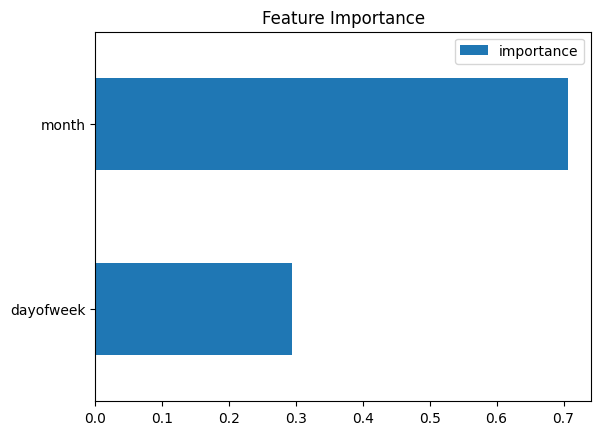

In [0]:
fi = pd.DataFrame(data=best_model.feature_importances_,
                  index=best_model.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title="Feature Importance")

## Prediction

/root/.ipykernel/1830/command-4368926398696470-712066016:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = best_model.predict(X_test)


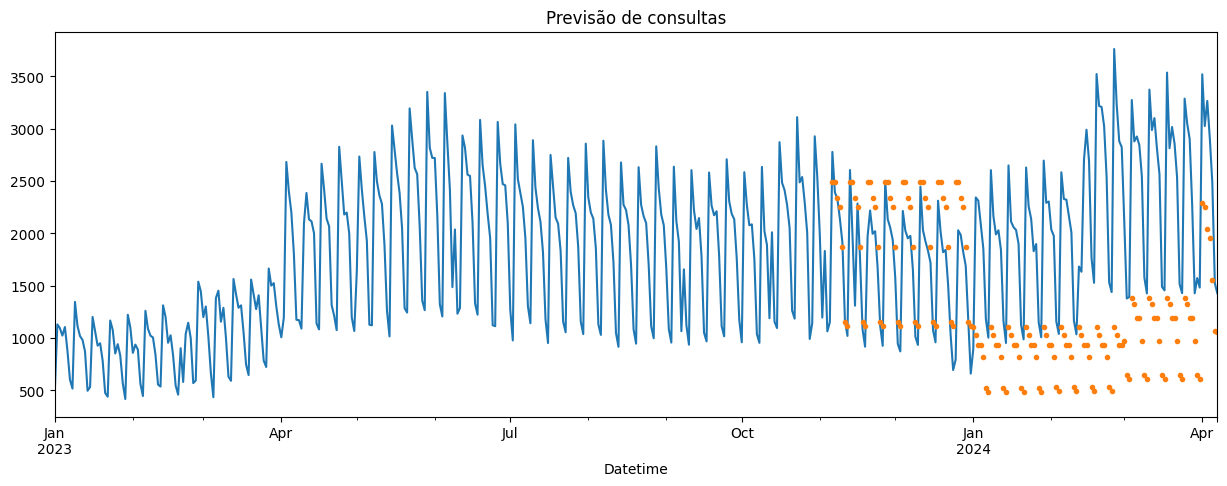

In [0]:
test['prediction'] = best_model.predict(X_test)
dfinal = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = dfinal["Consultas"].plot(figsize=(15, 5))
dfinal["prediction"].plot(ax=ax, style='.')
ax.set_title("Previsão de consultas")
plt.show()

/root/.ipykernel/1830/command-4368926398696472-1196207241:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = best_model.predict(X_test)


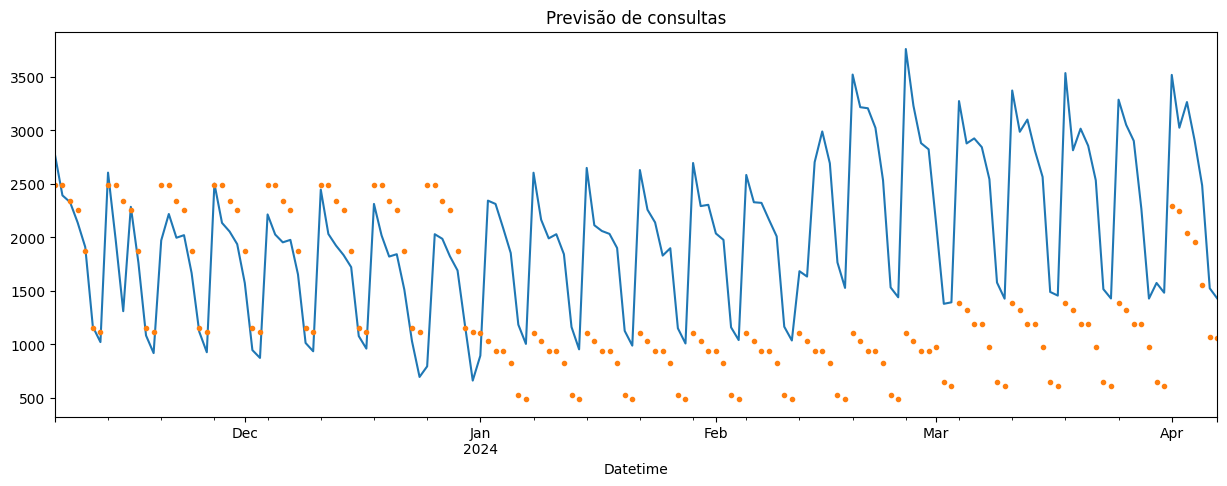

In [0]:
test['prediction'] = best_model.predict(X_test)
dfinal = df.merge(test[['prediction']], how='inner', left_index=True, right_index=True)
ax = dfinal["Consultas"].plot(figsize=(15, 5))
dfinal["prediction"].plot(ax=ax, style='.')
ax.set_title("Previsão de consultas")
plt.show()

In [0]:
future = pd.date_range(start=df.index.max(), periods=30, freq='D')
future = pd.DataFrame(index=future)
future = new_features(future)
future["IsFuture"] = True
df["IsFuture"] = False
future.head()

,dayofweek,month,quarter,year,IsFuture
2024-04-07,6,4,2,2024,True
2024-04-08,0,4,2,2024,True
2024-04-09,1,4,2,2024,True
2024-04-10,2,4,2,2024,True
2024-04-11,3,4,2,2024,True


In [0]:
df_and_future = pd.concat([df, future])
df_and_future.head(1000)

,Consultas,dayofweek,month,quarter,year,IsFuture
2023-01-01,503.0,6,1,1,2023,False
2023-01-02,1131.0,0,1,1,2023,False
2023-01-03,1095.0,1,1,1,2023,False
2023-01-04,1024.0,2,1,1,2023,False
2023-01-05,1106.0,3,1,1,2023,False
...,...,...,...,...,...,...
2024-05-02,NaN,3,5,2,2024,True
2024-05-03,NaN,4,5,2,2024,True
2024-05-04,NaN,5,5,2,2024,True
2024-05-05,NaN,6,5,2,2024,True


In [0]:
df_and_future["predictions"] =best_model.predict(df_and_future[['dayofweek', 'month']])

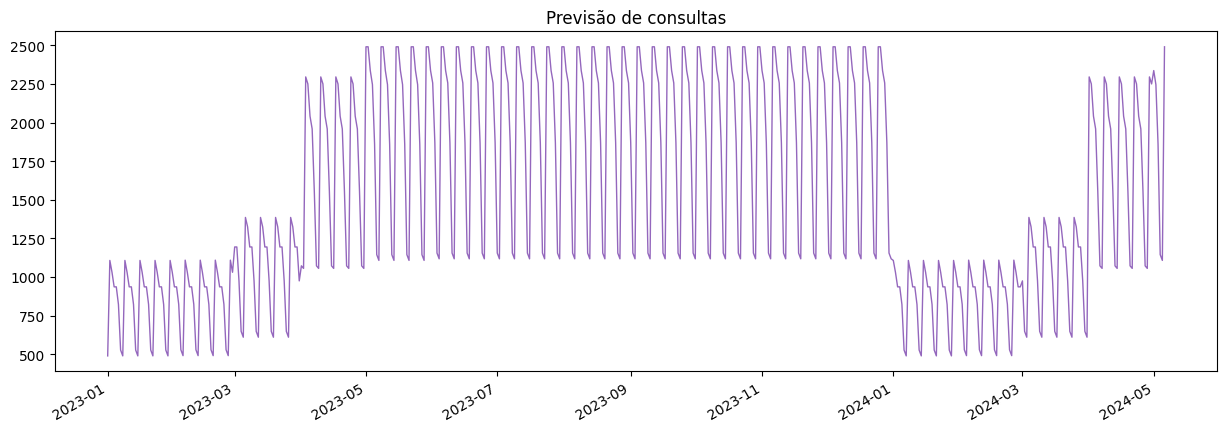

In [0]:
df_and_future["predictions"].plot(figsize=(15,5),
                                  color = color_pal[4],
                                  ms=1,
                                  lw=1,
                                  title="Previsão de consultas")
plt.show()